# El problema de clasificación que elegimos: 
Nosotros elegimos hacer una red neuronal para resolver el problema de MNIST que basicamente consiste en una serie de imágenes de dígitos escritos a mano alzada, entre 0 y 9. Cada dígito está representado por una imagen en blanco y negro. 

# Imports: 
Importo las librerías correspondientes

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip3 install keras-visualizer

import tensorflow as tf
import tensorflow_datasets as tfds

import math
import numpy as np
import matplotlib.pyplot as plt
import logging
logger = tf.get_logger()

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation
from keras_visualizer import visualizer 
from keras.utils.vis_utils import plot_model
from keras import models, layers  
from IPython.display import display, Image

logger.setLevel(logging.ERROR)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  Usamos el dataset que ya esta hecho en **Tensorflow**, llamado mnist. Ahí se encuentran todas las imagenes que vamos a utilizar luego.

In [2]:
dataset, metadata = tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Para el entrenamiento tenemos 60.000 imagenes de 28 x 28 pixeles de tamaño cada una. Y 10.000 para las pruebas, del mismo tamaño.

In [3]:
class_names = [
    '0', '1', '2', '3', '4', '5', '6',
    '7', '8', '9'
]

num_train_examples = metadata.splits['train'].num_examples

num_test_examples = metadata.splits['test'].num_examples
print(num_train_examples, num_test_examples)

60000 10000


# Normalizar los datos:

Hacemos una funcion para normalizar los datos, es decir que en vez de que los numeros esten entre 0 y 255 (el cual es el valor máximo de un pixel en una imagen (RGB=255,255,255)) van a estar entre 0 y 1. Aplicamos esta funcion a train_dataset y a test_dataset.

In [4]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# Estructura de los datos: 
Definimos la estructura de nuestra Red Neuronal. Primero indicamos la capa de entrada que cuenta con 784 neuronas y llegaran de una forma cuadrada de 28x28. Agregamos dos capas ocultas (Densas) de 64 neuronas cada una y por ultimo la capa de salida que también es densa y cuenta con 10 outputs (una por cada posible numero entre 0 y 9). 

Para las capas ocultas usamos el metodo de activación **relu** que es la función de activación más utilizada en el deep learning. Lo que hace es que los numeros negativos los convierte en 0 y los positivos los deja como están. Su formula es ReLU (z) = max(0,z)

Pero para la capa de salida utilizamos la función **softmax**. Esta función de activación devuelve la distribución de probabilidad de cada una de las clases soportadas en el modelo.

In [5]:
model = tf.keras.Sequential([
	tf.keras.layers.Flatten(input_shape=(28,28,1)),
	tf.keras.layers.Dense(64, activation=tf.nn.relu),
	tf.keras.layers.Dense(64, activation=tf.nn.relu),
	tf.keras.layers.Dense(10, activation=tf.nn.softmax)
 ])

Compilamos el modelo indicando el optimizador ("**Adam**") la función de costo que utilizamos ("**sparse_categorical_crossentropy**"). Guardamos la precisión de nuestra red para luego poder mostrarla en pantalla.

In [6]:
model.compile(
	optimizer='adam',
	loss='sparse_categorical_crossentropy',
	metrics=['accuracy']
)

# Entrenamiento del modelo:
Primero elegimos el tamaño del batch, es el número de muestras que se utilizan para actualizar los pesos cada vez.  En este caso es de 32.

In [8]:
BATCHSIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCHSIZE)
test_dataset = test_dataset.batch(BATCHSIZE)

Hacemos el aprendizaje con el metodo **fit**. En este se le indican la cantidad de epochs, es decir la cantidad de vueltas completas a todos los datos del set se usaran en el entrenamiento. A medida que van pasando los epochs la "accuracy", es cada vez más alta y la pérdida, cada vez más chica.

In [9]:
model.fit(
	train_dataset, epochs=5,
	steps_per_epoch=math.ceil(num_train_examples/BATCHSIZE) 
)

Epoch 1/5
1875/1875 [==============================] - 20s 8ms/step - loss: 0.2705 - accuracy: 0.9202
Epoch 2/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1240 - accuracy: 0.9630
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0909 - accuracy: 0.9722
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0709 - accuracy: 0.9777
Epoch 5/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0571 - accuracy: 0.9822


# Evaluación:
Comparamos nuestro modelo ya entrenado contra el dataset de pruebas.  Esto sirve para ver que tan bien entrenada quedo y darnos cuenta si es correcto la predicción que hace. Además tenemos la test_accuracy que basicamente es la precisión que tiene, en nuestro caso ronda el 97% y el test_loss que es la pérdida del modelo durante el entrenamiento.. 

In [10]:
test_loss, test_accuracy = model.evaluate(
	test_dataset, steps=math.ceil(num_test_examples/32)
)
print("Test Loss: {}, Precisión: {}".format(test_loss, test_accuracy))

313/313 [==============================] - 2s 5ms/step - loss: 0.0972 - accuracy: 0.9703
Test Loss: 0.09720350801944733, Precisión: 0.970300018787384


# Visualización de los resultados:
Con la libreria matplotlib generamos los graficos en los que se pueden ver cada foto que eligio, el numero predecido (el que estima que es correcto), y a su lado hay una grafico de barras con lo que sería su prediccion (entre cuales esta) que tiene en cada caso. Podemos notar que cuando está en verde es que está seguro de su respuesta pero hay veces que se pone en rojo ya que hay varías opciones posibles y no está claro cuál es la opción correcta. 

1/1 [==============================] - 0s 130ms/step


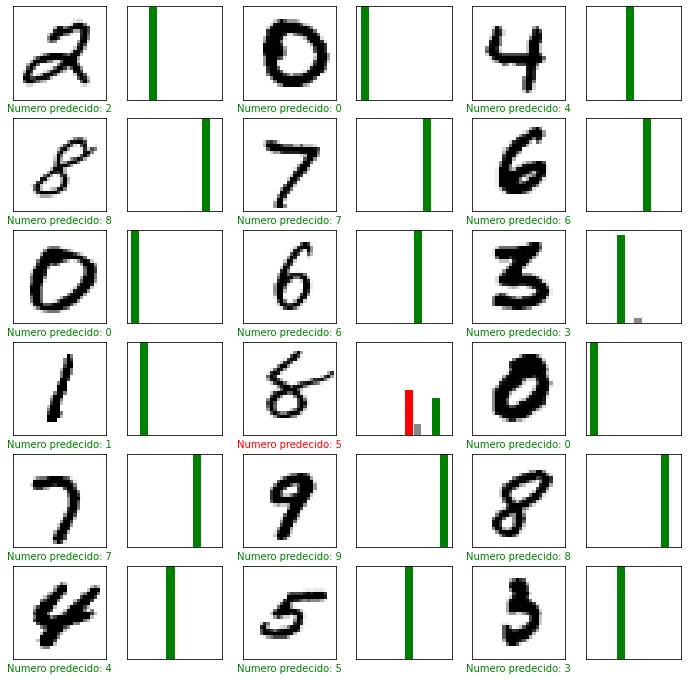

In [11]:
for test_images, test_labels in test_dataset.take(1):
	test_images = test_images.numpy()
	test_labels = test_labels.numpy()
	predictions = model.predict(test_images)
 
def plot_image(i, predictions_array, true_labels, images):
	predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
	plt.grid(False)
	plt.xticks([])
	plt.yticks([])

	plt.imshow(img[...,0], cmap=plt.cm.binary)

	predicted_label = np.argmax(predictions_array)
	if predicted_label == true_label:
		color = 'green'
	else:
		color = 'red'

	plt.xlabel("Numero predecido: {}".format(class_names[predicted_label]), color=color)

def plot_value_array(i, predictions_array, true_label):
	predictions_array, true_label = predictions_array[i], true_label[i]
	plt.grid(False)
	plt.xticks([])
	plt.yticks([])
	thisplot = plt.bar(range(10), predictions_array, color="#888888")
	plt.ylim([0,1])
	predicted_label = np.argmax(predictions_array)

	thisplot[predicted_label].set_color('red')
	thisplot[true_label].set_color('green')

numrows=6
numcols=3
numimages = numrows*numcols

plt.figure(figsize=(2*2*numcols, 2*numrows))
for i in range(numimages):
	plt.subplot(numrows, 2*numcols, 2*i+1)
	plot_image(i, predictions, test_labels, test_images)
	plt.subplot(numrows, 2*numcols, 2*i+2)
	plot_value_array(i, predictions, test_labels)

plt.show()